In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifierCV as RidgeClassifier
from sklearn.pipeline import make_pipeline

from sktime.transformations.panel.rocket import Rocket

import pandas as pd

In [2]:
path = "/Users/nraman/Documents/thesis_videos/"

lower = [76, 77, 90, 180, 85, 16, 315, 404, 320, 307]

upper = [184, 74, 73, 72, 11, 302, 303, 304, 408, 306]

u2 = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409]
l2 = [291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

u3 = [57, 186, 92, 165, 167, 164, 393, 391, 322, 410]
l3 = [287, 273, 335, 406, 313, 18, 83, 182, 106, 43]

combo_indices = lower + upper + u2 + l2 + u3 + l3

In [3]:
subfolders = [i for i in os.listdir(path) if ".mp4" not in i and ".DS_Store" not in i and "12_" not in i]

def find_pointfolder(subfolder, path = "/Users/nraman/Documents/thesis_videos/"):
    cur_path = f"{path}{subfolder}"
    # get names of files within the subfolder
    subfiles = os.listdir(f"{path}{subfolder}")
    nps = [i for i in subfiles if ".npy" in i]
    
    if(len(nps) > 1):
        return("Error: Multiple np arrays saved in the folder")
    else:
        array = np.load(f"{cur_path}/{nps[0]}")
        array = array[:, combo_indices]
        return(array.reshape(array.shape[0], len(combo_indices)*2))

In [4]:
ground_folders = [i for i in subfolders if "ground" in i]
speak_folders = [i for i in subfolders if "ground" not in i]

ground_data = []
speak_data = []

for g in ground_folders:
    ground_data.append(find_pointfolder(g))

for s in speak_folders:
    speak_data.append(find_pointfolder(s))

In [5]:
#pd.DataFrame(eval([speak_data[0][:, i] for i in range(len(combo_indices))]))
trainsize = len(ground_data) + len(speak_data)
trainplus = len(speak_data)
window = 12

df=pd.DataFrame(np.zeros([trainsize, len(combo_indices)*2]))
df=df.astype(object)  # this line allows the signment of the array

for j in range(trainsize):
    for a in range(len(combo_indices)*2):
        if(j < trainplus):
            cur = speak_data[j][:, a]
            df.iloc[j, a] = pd.Series(cur[-window:])
        else:
            it = j-trainplus
            cur = ground_data[it][:, a]
            df.iloc[j, a] = pd.Series(cur[:window])

In [6]:
# testsize = 20
# testplus = 7
# buffer = 12*(trainsize - trainplus)

# testX=pd.DataFrame(np.zeros((testsize, len(combo_indices)*2))).astype(object)

# for j in range(testsize):
#     for a in range(len(combo_indices)*2):
#         if(j < testplus):
#             testX.iloc[j, a] = pd.Series(speak_data[-j][:, a][:12])
#         else:
#             testX.iloc[j, a] = pd.Series(ground_data[(j-testplus)*12 + buffer: ((j-testplus)+1)*12 + buffer][:, a])

In [32]:
df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0 819.0 1 819.0 2 817.0 3 817....,0 639.0 1 637.0 2 637.0 3 636....,0 826.0 1 825.0 2 823.0 3 823....,0 653.0 1 652.0 2 651.0 3 649....,0 833.0 1 833.0 2 831.0 3 831....,0 666.0 1 666.0 2 664.0 3 662....,0 846.0 1 846.0 2 843.0 3 844....,0 679.0 1 680.0 2 678.0 3 675....,0 865.0 1 865.0 2 862.0 3 862....,0 690.0 1 692.0 2 690.0 3 686....,...,0 893.0 1 892.0 2 890.0 3 890....,0 736.0 1 736.0 2 735.0 3 732....,0 863.0 1 862.0 2 860.0 3 861....,0 730.0 1 731.0 2 729.0 3 726....,0 837.0 1 836.0 2 834.0 3 834....,0 713.0 1 713.0 2 712.0 3 709....,0 819.0 1 818.0 2 817.0 3 817....,0 691.0 1 690.0 2 689.0 3 687....,0 807.0 1 807.0 2 805.0 3 805....,0 667.0 1 665.0 2 665.0 3 663....
1,0 842.0 1 843.0 2 840.0 3 842....,0 434.0 1 435.0 2 435.0 3 436....,0 846.0 1 846.0 2 844.0 3 845....,0 445.0 1 445.0 2 445.0 3 445....,0 851.0 1 851.0 2 849.0 3 850....,0 455.0 1 455.0 2 454.0 3 454....,0 860.0 1 860.0 2 858.0 3 859....,0 465.0 1 466.0 2 465.0 3 464....,0 874.0 1 874.0 2 872.0 3 872....,0 475.0 1 477.0 2 475.0 3 473....,...,0 889.0 1 888.0 2 887.0 3 886....,0 514.0 1 515.0 2 513.0 3 512....,0 868.0 1 867.0 2 865.0 3 866....,0 507.0 1 507.0 2 506.0 3 505....,0 850.0 1 849.0 2 847.0 3 848....,0 492.0 1 492.0 2 491.0 3 490....,0 838.0 1 838.0 2 836.0 3 837....,0 474.0 1 474.0 2 473.0 3 473....,0 831.0 1 831.0 2 829.0 3 830....,0 455.0 1 455.0 2 455.0 3 455....
2,0 629.0 1 629.0 2 627.0 3 630....,0 406.0 1 407.0 2 405.0 3 409....,0 635.0 1 635.0 2 633.0 3 635....,0 412.0 1 413.0 2 411.0 3 415....,0 642.0 1 642.0 2 640.0 3 643....,0 418.0 1 419.0 2 417.0 3 421....,0 654.0 1 653.0 2 652.0 3 654....,0 425.0 1 426.0 2 424.0 3 428....,0 669.0 1 669.0 2 667.0 3 670....,0 431.0 1 433.0 2 431.0 3 434....,...,0 684.0 1 684.0 2 682.0 3 685....,0 460.0 1 461.0 2 460.0 3 462....,0 664.0 1 664.0 2 662.0 3 665....,0 457.0 1 458.0 2 457.0 3 460....,0 644.0 1 644.0 2 642.0 3 645....,0 448.0 1 449.0 2 447.0 3 450....,0 629.0 1 629.0 2 628.0 3 630....,0 435.0 1 436.0 2 434.0 3 438....,0 619.0 1 619.0 2 617.0 3 619....,0 422.0 1 422.0 2 421.0 3 424....
3,0 627.0 1 628.0 2 628.0 3 629....,0 404.0 1 405.0 2 405.0 3 405....,0 633.0 1 633.0 2 633.0 3 634....,0 411.0 1 412.0 2 411.0 3 412....,0 640.0 1 640.0 2 640.0 3 642....,0 418.0 1 418.0 2 418.0 3 418....,0 651.0 1 652.0 2 652.0 3 653....,0 424.0 1 425.0 2 425.0 3 425....,0 667.0 1 667.0 2 667.0 3 668....,0 431.0 1 432.0 2 431.0 3 431....,...,0 683.0 1 683.0 2 682.0 3 684....,0 460.0 1 460.0 2 460.0 3 460....,0 662.0 1 662.0 2 662.0 3 664....,0 457.0 1 457.0 2 457.0 3 457....,0 642.0 1 642.0 2 642.0 3 644....,0 447.0 1 448.0 2 447.0 3 448....,0 628.0 1 628.0 2 628.0 3 629....,0 434.0 1 435.0 2 434.0 3 435....,0 617.0 1 618.0 2 618.0 3 619....,0 421.0 1 421.0 2 421.0 3 421....
4,0 863.0 1 861.0 2 862.0 3 864....,0 436.0 1 437.0 2 438.0 3 441....,0 866.0 1 865.0 2 866.0 3 867....,0 446.0 1 448.0 2 447.0 3 451....,0 870.0 1 870.0 2 870.0 3 872....,0 456.0 1 457.0 2 457.0 3 460....,0 878.0 1 879.0 2 878.0 3 881....,0 467.0 1 468.0 2 467.0 3 471....,0 890.0 1 892.0 2 891.0 3 894....,0 477.0 1 478.0 2 476.0 3 481....,...,0 904.0 1 907.0 2 905.0 3 908....,0 515.0 1 516.0 2 515.0 3 518....,0 883.0 1 886.0 2 884.0 3 887....,0 507.0 1 508.0 2 508.0 3 511....,0 866.0 1 868.0 2 867.0 3 870....,0 492.0 1 493.0 2 493.0 3 496....,0 856.0 1 857.0 2 857.0 3 859....,0 473.0 1 475.0 2 475.0 3 478....,0 850.0 1 850.0 2 851.0 3 852....,0 454.0 1 457.0 2 457.0 3 460....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0 856.0 1 857.0 2 850.0 3 850....,0 517.0 1 522.0 2 516.0 3 513....,0 858.0 1 860.0 2 853.0 3 853....,0 528.0 1 531.0 2 526.0 3 522....,0 862.0 1 863.0 2 857.0 3 857....,0 538.0 1 540.0 2 535.0 3 530....,0 870.0 1 871.0 2 866.0 3 865....,0 548.0 1 550.0 2 545.0 3 539....,0 883.0 1 884.0 2 879.0 3 878....,0 557.0 1 560.0 2 554.0 3 548....,...,0 904.0 1 903.0 2 897.0 3 896....,0 591.0 1 595.0 2 591.0 3 587....,0 

In [7]:
ytrain = np.concatenate([np.ones(trainplus), np.zeros(trainsize - trainplus)])
#ytest = np.concatenate([np.ones(testplus), np.zeros(testsize - testplus)])

In [8]:
# df is for training
#train_y = np.concatenate([np.ones(30), np.zeros(30)])

rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
rocket.fit(df)
X_train_transform = rocket.transform(df)

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression as LR

classifier = LR()#RidgeClassifier(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, ytrain)

LogisticRegression()

In [10]:
print(classifier.predict(rocket.transform(df)))
print(ytrain)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
# NEW DATA!!!

testsubfolders = [i for i in os.listdir(path) if "12_" in i and ".DS_Store" not in i and "MOV" not in i]

testground = [i for i in testsubfolders if "ground" in i]
testspeak = [i for i in testsubfolders if "ground" not in i]

In [12]:
ground2 = []
speak2 = []

for g in testground:
    ground2.append(find_pointfolder(g))

for s in testspeak:
    speak2.append(find_pointfolder(s))

In [29]:
tsize2 = len(ground2) + len(speak2)
t2plus = len(speak2)

newtest=pd.DataFrame(np.zeros((tsize2, len(combo_indices)*2))).astype(object)

for j in range(tsize2):
    for a in range(len(combo_indices)*2):
        if(j < t2plus):
            newtest.iloc[j, a] = pd.Series(speak2[j][:, a][-36:-24])
        else:
            newtest.iloc[j, a] = pd.Series(ground2[j-t2plus][:, a][:12])

In [30]:
y2 = np.concatenate([np.ones(len(speak2)), np.zeros(len(ground2))])

In [31]:
print(classifier.predict(rocket.transform(newtest)))
print(y2)
print(classifier.score(rocket.transform(newtest), y2))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
1.0


In [17]:
x = []
y = []
k = ground2[0][0]

for el in range(int(len(k)/2)):
    x.append(k[el*2])
    y.append(k[el*2+1])

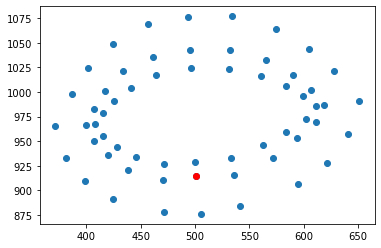

In [18]:
plt.scatter(x, y)
ix = 25
plt.scatter(ground2[0][0, ix*2], ground2[0][0, ix*2 + 1], c = "red")